In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.api._v2.keras.models import Sequential
from keras.api._v2.keras.layers import Flatten, Dense
from keras.api._v2.keras.optimizers import SGD
from scipy import stats
from sklearn import linear_model

In [14]:
df = pd.read_csv('batter_stats_2017.csv')
train_df = df[['타점','연봉(2018)']]

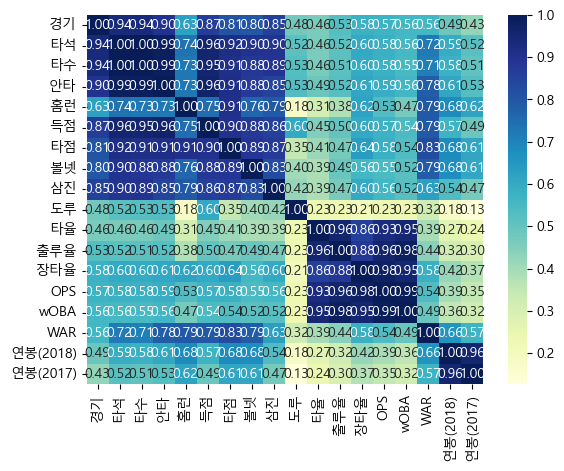

In [9]:
plt.rc('font', family='Malgun Gothic')
sns.heatmap(df.corr(numeric_only = True),annot=True, cmap="YlGnBu",fmt='.2f')
plt.show()

In [42]:
zscore_threshold = 1.8
outlier = train_df[np.abs(stats.zscore(train_df['연봉(2018)'].values))>zscore_threshold]

train_df = train_df.loc[np.isin(train_df['연봉(2018)'],outlier, invert=True)]
x_data = train_df['타점'].values.reshape(-1,1)
t_data = train_df['연봉(2018)'].values.reshape(-1,1)



In [44]:
# IQR value
iqr_value = np.percentile(train_df['연봉(2018)'],75) - np.percentile(train_df['연봉(2018)'],25)  
upper_fence = np.percentile(train_df['연봉(2018)'],75) + 1.5 * iqr_value
lower_fence = np.percentile(train_df['연봉(2018)'],25) - 1.5 * iqr_value

iqr_df = train_df[(train_df['연봉(2018)'] <= upper_fence) & (train_df['연봉(2018)'] >= lower_fence)]
x_data = iqr_df['타점'].values.reshape(-1,1)
t_data = iqr_df['연봉(2018)'].values.reshape(-1,1)

In [45]:
def numerical_derivative(f,x):

    # f : 미분하려고하는 다변수 함수
    # x : 모든 변수를 포함하는 ndarray  [1.0 2.0]
    # 리턴되는 결과는 [8.0 15.0]

    delta_x = 1e-4
    derivative_x = np.zeros_like(x)   #  [0.0 0.0]

    it = np.nditer(x, flags=['multi_index'])

    while not it.finished:

        idx = it.multi_index  # 현재의 index를 추출 => tuple형태로 리턴.

        tmp = x[idx]    # 현재 index의 값을 일단 잠시 보존해야해요!
                        # 밑에서 이 값을 변경해서 중앙차분 값을 계산해야 해요!
                        # 그런데 우리 편미분해야해요. 다음 변수 편미분할때
                        # 원래값으로 복원해야 편미분이 정상적으로 진행되기 때문에
                        # 이값을 잠시 보관했다가 원상태로 복구해야 해요!
        x[idx] = tmp + delta_x
        fx_plus_delta_x = f(x)  # f(x + delta_x)

        x[idx] = tmp - delta_x
        fx_minus_delta_x = f(x) # f(x - delta_x)

        derivative_x[idx] = (fx_plus_delta_x - fx_minus_delta_x) / (2 * delta_x)

        x[idx] = tmp

        it.iternext()

    return derivative_x

# Model을 만들어야 하는데.. y = Wx + b
W = np.random.rand(1,1)
b = np.random.rand(1)

# loss function(MSE)
def loss_func(input_data):

    input_w = input_data[0]
    input_b = input_data[1]

    y = np.dot(x_data, input_w) + input_b

    return np.mean(np.power((t_data-y),2))

# 모델이 완성된 후 예측하는 함수를 하나 만들어요!
def predict(x):

    return np.dot(x, W) + b

# learning rate 정의(hyperparameter)
learning_rate = 1e-4

# 학습진행
for step in range(300000):

    input_param = np.concatenate((W.ravel(), b.ravel()), axis=0)
    derivative_result = learning_rate * numerical_derivative(loss_func, input_param)

    W = W - derivative_result[0].reshape(-1,1)
    b = b - derivative_result[1]

    if step % 30000 == 0:
        print(f'W : {W}, b : {b}, loss : {loss_func(input_param)}')

W : [[65.60631088]], b : [2.59694172], loss : 138117466.33549097
W : [[252.21179493]], b : [3628.79319682], loss : 22228506.909473687
W : [[249.20606794]], b : [3768.74444985], loss : 22217026.4345547
W : [[249.08988148]], b : [3774.15426966], loss : 22217009.280289248
W : [[249.08539028]], b : [3774.36338649], loss : 22217009.254656762
W : [[249.08521667]], b : [3774.37147039], loss : 22217009.254618444
W : [[249.08521084]], b : [3774.37174177], loss : 22217009.25461839
W : [[249.08521084]], b : [3774.37174177], loss : 22217009.25461839
W : [[249.08521084]], b : [3774.37174177], loss : 22217009.25461839
W : [[249.08521084]], b : [3774.37174177], loss : 22217009.25461839


In [46]:
#파이썬 구현 모델 예측
print(predict(np.array([[100]])))

[[28682.89282565]]


In [47]:
# Model 생성
model = Sequential()

model.add(Flatten(input_shape=(1,)))

output_layer = Dense(units=1,
                     activation='linear')

model.add(output_layer)

# model 설정
model.compile(optimizer=SGD(learning_rate=1e-4),
              loss='mse')

# model 학습
model.fit(x_data,
          t_data,
          epochs=2000,
          verbose=0)

In [48]:
#케라스 구현 모델 예측
weights, bias = output_layer.get_weights()
print(model.predict(np.array([[100]])))

1/1 [==============================] - 0s 42ms/step
[[30031.531]]


In [49]:
# Model 생성
sklearn_model = linear_model.LinearRegression()

# Model 학습
sklearn_model.fit(x_data, t_data)

# 예측을 해 보아요!
print(sklearn_model.predict(np.array([[100]])))

[[28682.89276276]]


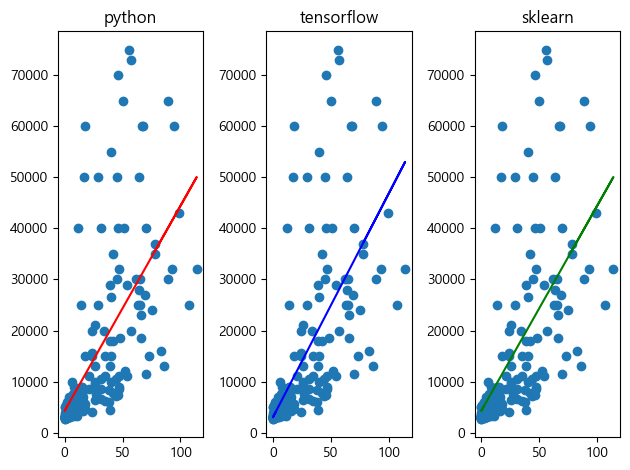

In [41]:
fig = plt.figure()

fig_python = fig.add_subplot(1,3,1)
fig_tensorflow = fig.add_subplot(1,3,2)
fig_sklearn = fig.add_subplot(1,3,3)

fig_python.set_title('python')
fig_tensorflow.set_title('tensorflow')
fig_sklearn.set_title('sklearn')

fig_python.scatter(x_data, t_data)
fig_python.plot(x_data, x_data*W.ravel() + b, color='r')

fig_tensorflow.scatter(x_data, t_data)
fig_tensorflow.plot(x_data, x_data*weights + bias, color='b')

fig_sklearn.scatter(x_data, t_data)
fig_sklearn.plot(x_data,
                 x_data*sklearn_model.coef_ + sklearn_model.intercept_,
                 color='g')

plt.tight_layout()
plt.show()